# Appendix Part 2: GREG Database Wrangling

This notebook is included separately, because it contains the code used to transform the GREG dataset into values in a suitable format to swap in for the withheld WLMS data.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Import Shapefiles

In [2]:
virtual = gpd.read_file('data_raw/Virtual_country')
virtual[['uniq_cnt25', 'point5_id', 'geometry']].head()

,uniq_cnt25,point5_id,geometry
0,39,247867.0,"POLYGON ((-86.00000 82.00000, -86.50000 82.000..."
1,40,247868.0,"POLYGON ((-85.50000 82.00000, -86.00000 82.000..."
2,40,247869.0,"POLYGON ((-85.00000 82.00000, -85.50000 82.000..."
3,40,247870.0,"POLYGON ((-84.50000 82.00000, -85.00000 82.000..."
4,40,247871.0,"POLYGON ((-84.00000 82.00000, -84.50000 82.000..."


In [3]:
greg = gpd.read_file('greg')
greg[['G1SHORTNAM', 'G2SHORTNAM', 'G3SHORTNAM', 'geometry']].head()

,G1SHORTNAM,G2SHORTNAM,G3SHORTNAM,geometry
0,Curaçao Islanders,None,None,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,English-speaking population of the Lesser Anti...,None,None,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Baloch,Brahui,None,"POLYGON ((64.03937 30.02453, 64.03937 30.11267..."
3,Persians,Afghans,None,"POLYGON ((61.75456 30.78628, 61.75833 30.79028..."
4,Afghans,Tajiks,None,"POLYGON ((61.62285 31.39536, 61.64841 31.46713..."


Before proceeding must check that the two shapefiles follow the same coordinate reference system, in this case, WGS84.

In [4]:
virtual.crs == greg.crs

True

## Transform GREG

The original GREG format is a number of regions, each of which has up to three ethnic groups attached to it. Ethnic groups may also be attached to different regions. This code chunk melts, and then dissolves, the original `greg` dataset, such that we have one entry per ethnic group.

In [5]:
melted = pd.melt(greg, id_vars = ['geometry'], value_vars = ['G1SHORTNAM', 'G2SHORTNAM', 'G3SHORTNAM'], value_name = 'SHORTNAM')
ethnicGroups = melted[melted['SHORTNAM'].notna()].drop('variable', axis = 1).dissolve(by = 'SHORTNAM', aggfunc = 'first', as_index = False)
ethnicGroups

,SHORTNAM,geometry
0,Abazinians,"MULTIPOLYGON (((41.83519 44.08370, 41.86445 44..."
1,Abkhaz,"MULTIPOLYGON (((41.73878 42.62086, 41.71329 42..."
2,Achaguas,"MULTIPOLYGON (((-74.02123 2.16973, -73.98634 2..."
3,Achang,"POLYGON ((97.84312 24.33767, 97.84467 24.36087..."
4,Achinese,"MULTIPOLYGON (((97.81446 2.77691, 97.86672 2.7..."
...,...,...
923,Zagawa,"MULTIPOLYGON (((25.88538 14.53904, 25.83321 14..."
924,Zakhchins,"POLYGON ((91.54557 47.36713, 91.54557 47.43751..."
925,Zapotecs,"POLYGON ((-94.96082 16.37316, -95.03084 16.322..."
926,Zoque,"MULTIPOLYGON (((-93.18895 16.87464, -93.13737 ..."


## Perform Intersection

This cell intersects the imported dataset of cells with the dataset of ethnic groups, derived from GREG.

In [6]:
joined = gpd.overlay(virtual, ethnicGroups, how = 'intersection')
joined.head()

,uniq_cnt25,point5_id,pop95,maize,pasture,suit_new,sorghum,allcrops,SHORTNAM,geometry
0,211,247281.0,0.0301,0.0,0.0,0.0000,0.0,0.0,Eskimos,"MULTIPOLYGON (((-19.00000 81.71801, -19.14417 ..."
1,211,247282.0,0.0300,0.0,0.0,0.0000,0.0,0.0,Eskimos,"MULTIPOLYGON (((-19.00000 81.80707, -18.99083 ..."
2,335,241416.0,0.0271,0.0,0.0,0.0001,0.0,0.0,Eskimos,"POLYGON ((-72.00000 78.00000, -71.87679 78.000..."
3,335,242134.0,0.0195,0.0,0.0,0.0001,0.0,0.0,Eskimos,"MULTIPOLYGON (((-73.00000 78.17449, -72.99834 ..."
4,335,242135.0,0.0330,0.0,0.0,0.0001,0.0,0.0,Eskimos,"POLYGON ((-72.34038 78.00000, -72.34695 78.003..."


## Coverage

These cells reduce each virtual country to *only contain cells in which the cell is completely covered by an ethnic group from GREG*, similar to our interpretation of the procedure described in Michalopolous.

First, we calculate the "area" of each small cell after it has been intersected with the transformed GREG dataset. Then we compare this area to the area of the full cell, and equaivalent areas indicate that the cell is completely covered.

In [7]:
dissolved = joined[['point5_id', 'geometry']].dissolve('point5_id')
areasCell = dissolved.area.to_frame().rename(columns = {0: 'overlay'})
areasCell['full'] = virtual.set_index('point5_id').area
areasCell['complete'] = np.isclose(areasCell['overlay'], areasCell['full'])
areasCell

/opt/homebrew/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: divide by zero encountered in unary_union
  result = lib.unary_union(collections, **kwargs)
/var/folders/l7/_yl1rg512jv095gql7v0v5r00000gn/T/ipykernel_50548/310672282.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areasCell = dissolved.area.to_frame().rename(columns = {0: 'overlay'})
/var/folders/l7/_yl1rg512jv095gql7v0v5r00000gn/T/ipykernel_50548/310672282.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areasCell['full'] = virtual.set_index('point5_id').area


,overlay,full,complete
point5_id,,,
49903.0,0.040962,0.25,False
49904.0,0.111268,0.25,False
49905.0,0.112302,0.25,False
49906.0,0.006557,0.25,False
50621.0,0.006873,0.25,False
...,...,...,...
242136.0,0.185729,0.25,False
242137.0,0.013326,0.25,False
242857.0,0.033278,0.25,False


This cell merges the overlay dataset calculated earlier with the coverage dataset, to determine whether each cell-ethnic group combination is of a cell with complete coverage.

In [8]:
joinedCoverage = joined.merge(areasCell, left_on = 'point5_id', right_index = True)
joinedCoverage[['uniq_cnt25', 'point5_id', 'complete']].head()

,uniq_cnt25,point5_id,complete
0,211,247281.0,False
1,211,247282.0,False
2,335,241416.0,False
3,335,242134.0,False
4,335,242135.0,False


Finally, we group by the virtual country ID, and count the number of unique ethnic groups (`SHORTNAM`), along with the number of complete cells (`point5_id`).

In [9]:
countries = joinedCoverage[joinedCoverage['complete'] == True].groupby('uniq_cnt25')[['point5_id', 'SHORTNAM']].nunique()
countries.to_csv('greg.csv')

In [10]:
len(countries)

2521

Text(0.5, 0, 'Number of Ethnic Groups in Virtual Country')

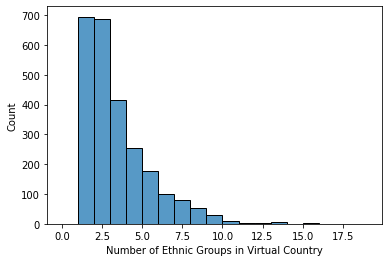

In [11]:
ax = sns.histplot(x = countries['SHORTNAM'], bins = np.arange(0, 20))
ax.set_xlabel('Number of Ethnic Groups in Virtual Country')

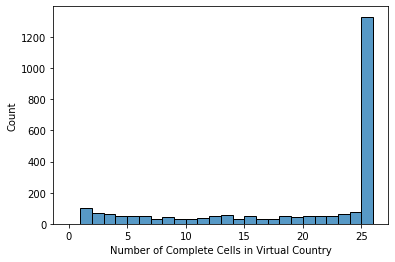

In [13]:
ax = sns.histplot(x = countries['point5_id'], bins = np.arange(27))
ax.set_xlabel('Number of Complete Cells in Virtual Country');

## Comparison to WLMS

When calculating number of ethnic groups per virtual country, we obtained 2521 countries with full coverage in at least one of its 25 cells. 1857 of these countries are included in the dataset derived from WLMS provided in the data download. 31 of the countries included in the data downloaded are *not* included in the 2521 countries we obtained.

In [14]:
df = pd.read_stata('data_raw/Tables4-7b.dta')
df['uniq_cnt25'] = df['uniq_cnt25'].astype(int)

In [15]:
len(df)

1888

In [16]:
countries.index.isin(df['uniq_cnt25']).sum()

1857

In [17]:
df['uniq_cnt25'].isin(countries.index).sum()

1857